In [2]:
import numpy as np
import pandas as pd
import glob
import os

### Paper data

In [6]:
input = np.load("/Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/wearable-project/data preprocessing/s999/lthigh/gyr.npy")
print(input.shape)
print(input)

(4600, 3)
[[-1.12451159 -1.78521417  3.30352171]
 [-1.11142918 -1.84789691  3.37391888]
 [-1.10049887 -1.86150035  3.44555718]
 ...
 [-0.3758165   1.26476693 -1.03840538]
 [-0.38596696  1.3359158  -1.06075689]
 [-0.38177557  1.3909236  -1.07753919]]


In [7]:
label = np.load("/Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/wearable-project/data preprocessing/s999/lankle/angle.npy")
print(label.shape)
print(label)

(4600, 3)
[[  5.09249264  -7.5996024  -12.61360109]
 [  4.72438656  -7.57943448 -12.25711487]
 [  4.37830979  -7.54552855 -11.8421057 ]
 ...
 [-10.0993935   -4.56046515  -0.82373543]
 [-10.25273302  -4.61637978  -0.92882851]
 [-10.40019937  -4.68304039  -1.03708614]]


### External data preprocessing (Dataset 1)

### Create folder

In [12]:
processed_data_path = "/Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/wearable-project/data preprocessing/Data/Processed_external_data_2"

In [5]:
patients = ['AB01', 'AB02', 'AB03', 'AB05', 'AB06', 'AB07', 'AB08', 'AB09', 
            'AB10', 'AB11', 'AB12', 'AB13']
motions = ['Walk', 'Run']
# Define body parts to extract
body_parts = ["Pelvis", "LeftThigh", "RightThigh", "LeftShank", "RightShank", "LeftFoot", "RightFoot"]
angle_parts = ["LeftAnkleAngle", "RightAnkleAngle", "LeftHipAngle", "RightHipAngle", "LeftKneeAngle", "RightKneeAngle"]
for patient in patients:
    for motion in motions:
        for part in body_parts:
            os.makedirs(os.path.join(processed_data_path, patient, motion, part), exist_ok=True)

### Generate npy files

In [9]:
folder_path = "/Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/wearable-project/data preprocessing/Data/ProcessedData"

In [13]:
def generate_angle_npy(folder_path):
    # Get all subdirectories (SUB folders)
    sub_dirs = sorted(glob.glob(f"{folder_path}/*/"))
    
    for sub_dir in sub_dirs:
        patient_number = os.path.basename(os.path.normpath(sub_dir))
        for category in ["normal_walk_1_1-2", "tire_run_1"]:
            category_path = os.path.join(sub_dir, category)
            file_paths = sorted(glob.glob(f"{category_path}/*angle.csv"))

            if not file_paths:
                print(f"No Merged files found in {category_path}")
                continue

            # Read CSV normally (first row is the actual header)
            df = pd.read_csv(file_paths[0])

            # Define joint names and movement types
            joint_parts = ["hip", "knee", "ankle", "subtalar"]
            movements = ["flexion", "adduction", "rotation"]
            sides = ["r", "l"]

            for side in sides:
                for joint in joint_parts:
                    # Extract columns related to this joint
                    if joint in ["hip"]:  # Hip has flexion, adduction, rotation
                        joint_columns = [col for col in df.columns if col.startswith(f"{joint}_") and col.endswith(f"_{side}")]
                        sorted_columns = sorted(joint_columns, key=lambda x: movements.index(x.split("_")[1]))  # Sort X, Y, Z
                    else:  # Knee, ankle, subtalar only have "angle"
                        joint_columns = [col for col in df.columns if col.startswith(f"{joint}_angle_{side}")]
                        sorted_columns = joint_columns  # No need to sort since there's only one column

                    # Extract data and ensure it has shape (n,3) for hip, (n,1) for others
                    if joint in ["hip"] and len(sorted_columns) == 3:
                        angles_data = df[sorted_columns].to_numpy()
                    elif joint in ["knee", "ankle", "subtalar"] and len(sorted_columns) == 1:
                        angles_data = df[sorted_columns].to_numpy()
                    else:
                        print(f"Skipping {joint}_{side}, missing data")
                        continue

                    # Define output path
                    output_path = os.path.join(processed_data_path, patient_number, category, f"{joint}_{side}")
                    os.makedirs(output_path, exist_ok=True)  # Ensure directory exists
                    
                    # Save as .npy
                    np.save(os.path.join(output_path, "angle.npy"), angles_data)

generate_angle_npy(folder_path)


No Merged files found in /Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/wearable-project/data preprocessing/Data/ProcessedData/AB07/normal_walk_1_1-2


In [12]:
folder_path = "/Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/Milestone2/Data/ProcessedData/"

In [ ]:
def generate_imu_npy(folder_path):
    # Get all subdirectories (SUB folders)
    sub_dirs = sorted(glob.glob(f"{folder_path}/*/"))
    
    for sub_dir in sub_dirs:
        patient_number = os.path.basename(os.path.normpath(sub_dir))
        for category in ["normal_walk_1_1-2", "tire_run_1"]:  # Ensure category is a list
            category_path = os.path.join(sub_dir, category)
            file_paths = sorted(glob.glob(f"{category_path}/*_imu_sim.csv"))

            if not file_paths:
                print(f"No files found in {category_path}")
                continue

            # Read CSV using the first row as headers
            df = pd.read_csv(file_paths[0])  # No header=None, since first row is the header

            # Define body parts to extract
            body_parts = ["Pelvis_V", "LThigh_V", "RThigh_V", "LShank_V", "RShank_V", "LFoot_V", "RFoot_V"]
            for part in body_parts:
                # Extract Accelerometer and Gyroscope data for X, Y, Z
                acc_columns = [col for col in df.columns if f"{part}_ACC" in col]  # Match "ACCX", "ACCY", "ACCZ"
                gyr_columns = [col for col in df.columns if f"{part}_GYRO" in col]  # Match "GYROX", "GYROY", "GYROZ"

                # Ensure correct order of X, Y, Z
                acc_columns_sorted = sorted(acc_columns, key=lambda x: ['X', 'Y', 'Z'].index(x[-1])) if acc_columns else []
                gyr_columns_sorted = sorted(gyr_columns, key=lambda x: ['X', 'Y', 'Z'].index(x[-1])) if gyr_columns else []

                # Extract data and ensure shape (n,3)
                acc_data = df[acc_columns_sorted].to_numpy() if acc_columns_sorted else None
                gyr_data = df[gyr_columns_sorted].to_numpy() if gyr_columns_sorted else None

                # Save as .npy files if valid data exists
                output_path = os.path.join(processed_data_path, patient_number, category, part)
                os.makedirs(output_path, exist_ok=True)  # Ensure directory exists
                
                if acc_data is not None and acc_data.shape[1] == 3:
                    np.save(os.path.join(output_path, "acc.npy"), acc_data)
                
                if gyr_data is not None and gyr_data.shape[1] == 3:
                    np.save(os.path.join(output_path, "gyr.npy"), gyr_data)

generate_imu_npy(folder_path)


No files found in /Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/Milestone2/Data/ProcessedData/AB07/normal_walk_1_1-2


### Convert .npy into .h5

In [ ]:
import h5py

npy_directory = "/Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/Milestone2/Preprocessed_data/"  # Change this to your npy folder
def convert_to_h5(folder_path):
# Define paths
    h5_filename = "Data.h5"
    # Create an HDF5 file
    with h5py.File(h5_filename, 'w') as h5f:
        for root, _, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".npy"):
                    file_path = os.path.join(root, file)
                    print(file_path)
                    data = np.load(file_path, allow_pickle=True)  # Load .npy file

                    # Create a dataset name based on the file structure
                    dataset_name = os.path.relpath(file_path, folder_path).replace(os.sep, "/").replace(".npy", "")

                    # Store in HDF5
                    h5f.create_dataset(dataset_name, data=data)

                    print(f"Saved {file_path} as {dataset_name} in {h5_filename}")

    print(f"Conversion complete! Data saved in {h5_filename}")

/Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/Milestone2/Preprocessed_data/Walk/SUB11/LeftShank/gyr.npy
Saved /Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/Milestone2/Preprocessed_data/Walk/SUB11/LeftShank/gyr.npy as Walk/SUB11/LeftShank/gyr in Data.h5
/Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/Milestone2/Preprocessed_data/Walk/SUB11/LeftShank/acc.npy
Saved /Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/Milestone2/Preprocessed_data/Walk/SUB11/LeftShank/acc.npy as Walk/SUB11/LeftShank/acc in Data.h5
/Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/Milestone2/Preprocessed_data/Walk/SUB11/RightHipAngle/angle.npy
Saved /Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/Milestone2/Preprocessed_data/Walk/SUB11/RightHipAngle/angle.npy as Walk/SUB11/RightHipAngle/angle in Data.h5
/Users/ccy/Documents/CMU/Spring

### Rotate axis

In [ ]:
import numpy as np

def rotate_imu(data, axis, angle):
    """
    Rotate imu direction
    
    Parameters:
    - data: numpy array, (n, 3) -> X, Y, Z 
    - axis: str（'x', 'y', 'z'）
    - angle: int，(90,180,270)

    Returns:
    - numpy array
    """
    angle_rad = np.deg2rad(angle)  
    
    if axis == 'x':
        rotation_matrix = np.array([
            [1, 0, 0],
            [0, np.cos(angle_rad), -np.sin(angle_rad)],
            [0, np.sin(angle_rad), np.cos(angle_rad)]
        ])
    elif axis == 'y':
        rotation_matrix = np.array([
            [np.cos(angle_rad), 0, np.sin(angle_rad)],
            [0, 1, 0],
            [-np.sin(angle_rad), 0, np.cos(angle_rad)]
        ])
    elif axis == 'z':
        rotation_matrix = np.array([
            [np.cos(angle_rad), -np.sin(angle_rad), 0],
            [np.sin(angle_rad), np.cos(angle_rad), 0],
            [0, 0, 1]
        ])
    else:
        raise ValueError("axis should be 'x', 'y', or 'z'")

    rotated_data = data @ rotation_matrix.T
    return rotated_data


### Gait cycle

In [ ]:
pred = np.load("/Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/Milestone2/y_pred_test.npy")
print(pred.shape)
print(pred)

(176, 3200, 3)
[[[-5.55725861e+00 -2.58759046e+00 -2.22012424e+00]
  [-4.93927526e+00 -2.54196167e+00 -2.10470438e+00]
  [-4.52566481e+00 -2.47922564e+00 -2.09574986e+00]
  ...
  [-1.29237185e+01  1.19535923e-01 -8.82862806e-01]
  [-1.35984631e+01 -8.67782831e-02 -1.08632946e+00]
  [-1.40239458e+01 -1.81169033e-01 -1.19791329e+00]]

 [[-1.37979383e+01 -7.71195889e-02 -3.37110019e+00]
  [-1.44335175e+01 -5.79271317e-02 -3.38411760e+00]
  [-1.50871725e+01 -1.26153588e-01 -3.58892536e+00]
  ...
  [-1.30017729e+01 -3.18059158e+00 -4.14649963e+00]
  [-1.29444237e+01 -3.12808681e+00 -3.91930819e+00]
  [-1.26186152e+01 -3.01591921e+00 -3.63463879e+00]]

 [[-1.28198586e+01  3.11686993e-02 -3.16817141e+00]
  [-1.27828598e+01 -1.03539228e-02 -3.20128536e+00]
  [-1.28152723e+01 -3.13386917e-02 -3.25864744e+00]
  ...
  [-1.34212770e+01 -5.60848415e-01 -2.93698359e+00]
  [-1.29633656e+01 -6.35749102e-01 -2.92124319e+00]
  [-1.25351696e+01 -6.47519529e-01 -2.82223511e+00]]

 ...

 [[-6.60606956e+00 

In [11]:
gt = np.load("/Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/Milestone2/y_test.npy")
print(gt.shape)
print(gt)

(176, 3200, 3)
[[[ 1.6725740e+00 -1.1535536e+01  3.8670382e+00]
  [ 2.2928085e+00 -1.1419611e+01  4.0592308e+00]
  [ 2.9616470e+00 -1.1313931e+01  4.2660003e+00]
  ...
  [-2.1646021e+01 -1.4685881e-01 -5.6819329e+00]
  [-2.2552916e+01  4.0066361e-02 -6.7045527e+00]
  [-2.3377020e+01  2.6909781e-01 -7.5725884e+00]]

 [[-2.9360325e+01  5.5129247e+00 -4.5273829e+00]
  [-2.9210882e+01  5.4676461e+00 -4.6635656e+00]
  [-2.8943167e+01  5.2956185e+00 -4.6508622e+00]
  ...
  [-8.6109781e+00 -5.4316373e+00  4.1396208e+00]
  [-7.7078586e+00 -5.4293933e+00  4.5244608e+00]
  [-6.8120661e+00 -5.4048824e+00  4.8755322e+00]]

 [[-2.8306570e+01  4.1395369e+00 -1.6218027e+01]
  [-2.7858610e+01  4.1313505e+00 -1.6201612e+01]
  [-2.7431580e+01  4.1270061e+00 -1.6195858e+01]
  ...
  [-3.2042629e+01  3.2158351e+00 -1.7694433e+01]
  [-3.1492867e+01  3.1834531e+00 -1.7766903e+01]
  [-3.0962240e+01  3.1624084e+00 -1.7845497e+01]]

 ...

 [[ 1.3051771e+01 -7.3594993e-01 -8.3233995e+00]
  [ 1.3440241e+01 -7.606

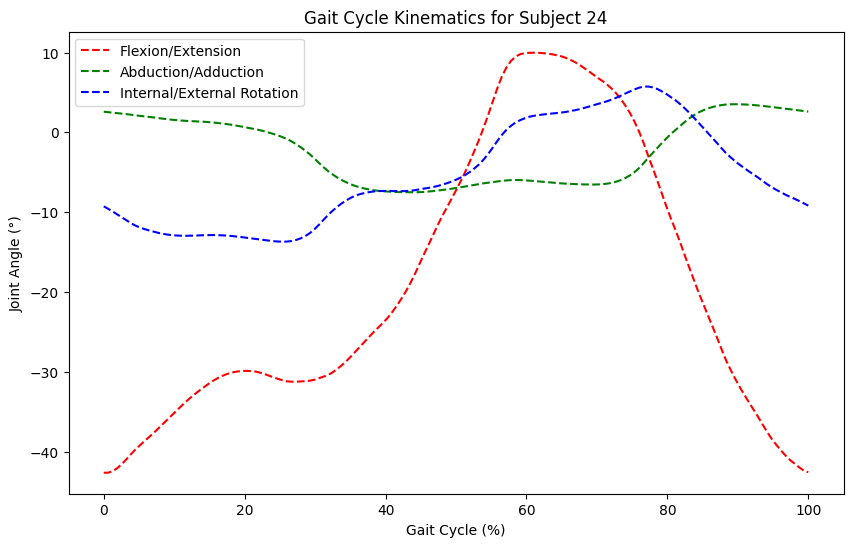

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


y_pred = np.load("/Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/Milestone2/Prediction/Hip/Running/y_pred_test.npy")  #
y_test = np.load("/Users/ccy/Documents/CMU/Spring2025/42696 Wearable Health Technology/Projects/Milestone2/Prediction/Hip/Running/y_test.npy")  # 

# 選擇單一受試者 (例如 index=0)
subject_index = 24
subject_data = y_pred[subject_index]  # shape: (3200, 3)

# 分離三種角度
flexion = subject_data[:, 0]  # 屈曲/伸展
abduction = subject_data[:, 1]  # 外展/內收
rotation = subject_data[:, 2]  # 內旋/外旋

# 找到 gait cycle (使用 flexion 最小值來標記 heel strike)
peaks, _ = find_peaks(-flexion, distance=100)  # 取局部最小值作為 Heel Strike

# 確保至少有兩個 Heel Strike 點
if len(peaks) < 2:
    raise ValueError("Not enough gait cycles detected.")

# 取前兩個 Heel Strike 作為 gait cycle 邊界
gait_cycle_indices = peaks[:2]
gait_cycle_range = np.linspace(0, 100, gait_cycle_indices[1] - gait_cycle_indices[0])

# 擷取 gait cycle 內的數據
flexion_gait = flexion[gait_cycle_indices[0]:gait_cycle_indices[1]]
abduction_gait = abduction[gait_cycle_indices[0]:gait_cycle_indices[1]]
rotation_gait = rotation[gait_cycle_indices[0]:gait_cycle_indices[1]]

# 繪圖
plt.figure(figsize=(10, 6))
plt.plot(gait_cycle_range, flexion_gait, 'r--', label="Flexion/Extension")
plt.plot(gait_cycle_range, abduction_gait, 'g--', label="Abduction/Adduction")
plt.plot(gait_cycle_range, rotation_gait, 'b--', label="Internal/External Rotation")
plt.xlabel("Gait Cycle (%)")
plt.ylabel("Joint Angle (°)")
plt.legend()
plt.title(f"Gait Cycle Kinematics for Subject {subject_index}")
plt.show()


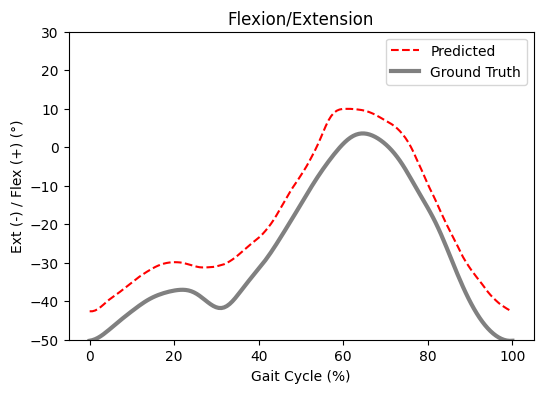

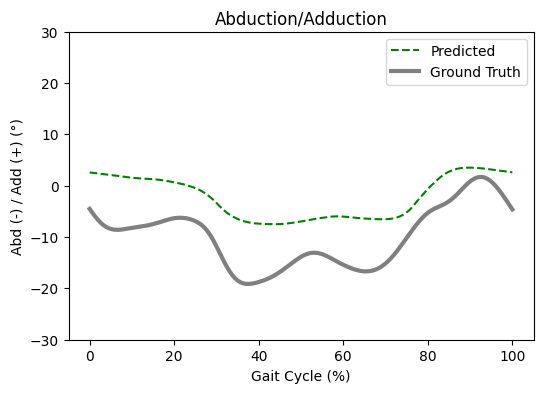

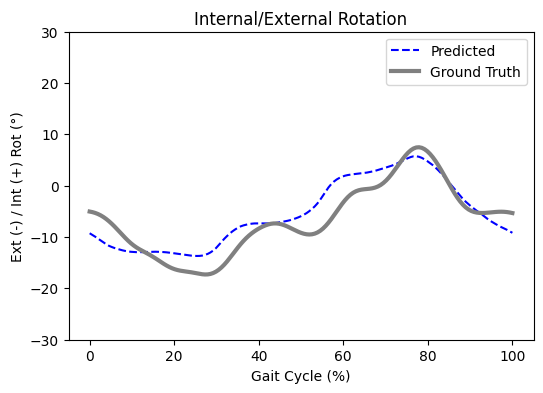

In [30]:
import matplotlib.pyplot as plt

# 讀取 Ground Truth 數據
subject_test_data = y_test[subject_index]  # shape: (3200, 3)

# 擷取 gait cycle 內的 Ground Truth 數據
flexion_gait_test = subject_test_data[gait_cycle_indices[0]:gait_cycle_indices[1], 0]
abduction_gait_test = subject_test_data[gait_cycle_indices[0]:gait_cycle_indices[1], 1]
rotation_gait_test = subject_test_data[gait_cycle_indices[0]:gait_cycle_indices[1], 2]

# 設定 Y 軸範圍 (根據論文圖表調整)
flexion_ylim = (-50, 30)
abduction_ylim = (-30, 30)
rotation_ylim = (-30, 30)

# 繪製 Flexion 圖
plt.figure(figsize=(6, 4))
plt.plot(gait_cycle_range, flexion_gait, 'r--', label="Predicted")
plt.plot(gait_cycle_range, flexion_gait_test, 'gray', linewidth=3, label="Ground Truth")
plt.xlabel("Gait Cycle (%)")
plt.ylabel("Ext (-) / Flex (+) (°)")
plt.ylim(flexion_ylim)
plt.legend()
plt.title("Flexion/Extension")
plt.show()

# 繪製 Abduction 圖
plt.figure(figsize=(6, 4))
plt.plot(gait_cycle_range, abduction_gait, 'g--', label="Predicted")
plt.plot(gait_cycle_range, abduction_gait_test, 'gray', linewidth=3, label="Ground Truth")
plt.xlabel("Gait Cycle (%)")
plt.ylabel("Abd (-) / Add (+) (°)")
plt.ylim(abduction_ylim)
plt.legend()
plt.title("Abduction/Adduction")
plt.show()

# 繪製 Rotation 圖
plt.figure(figsize=(6, 4))
plt.plot(gait_cycle_range, rotation_gait, 'b--', label="Predicted")
plt.plot(gait_cycle_range, rotation_gait_test, 'gray', linewidth=3, label="Ground Truth")
plt.xlabel("Gait Cycle (%)")
plt.ylabel("Ext (-) / Int (+) Rot (°)")
plt.ylim(rotation_ylim)
plt.legend()
plt.title("Internal/External Rotation")
plt.show()
